# a) Problem Statement

The goal of this project is to predict whether a customer in a Telecommunication company will churn or not.
By identifying important features that contribute to churn, the company can take proactive measures to retain customers
and improve customer satsifaction.

# b) Exploratory Data Analysis

In [1]:
#import necessary packages 
import findspark
findspark.init()
from pyspark.sql import SparkSession


In [2]:
#creating spark session
spark = SparkSession.builder.getOrCreate()

In [3]:
#reading dataset and printing the column names
df=spark.read.csv("Modified_WA_Fn-UseC_-Telco-Customer-Churn.csv",header=True,inferSchema=True)
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [4]:
#Changing the types of TotalCharges from string to double
from pyspark.sql.functions import col
df=df.withColumn("TotalCharges",col("TotalCharges").cast("double"))

In [5]:
#Descriptive Statistics of numerical features
df.select('tenure',"TotalCharges").describe().show()

+-------+------------------+------------------+
|summary|            tenure|      TotalCharges|
+-------+------------------+------------------+
|  count|              7043|              7032|
|   mean| 32.37114865824223|2283.3004408418697|
| stddev|24.559481023094442| 2266.771361883145|
|    min|                 0|              18.8|
|    max|                72|            8684.8|
+-------+------------------+------------------+



In [6]:
#creating temporary table for analysing dataset using sql
temp_table_name="churn_analysis"
df.createOrReplaceTempView(temp_table_name)

In [7]:
#obtaining count of customers who churn or fail to churn
spark.sql("select churn,count(*) from churn_analysis group by Churn").show()

+-----+--------+
|churn|count(1)|
+-----+--------+
|   No|    5174|
|  Yes|    1869|
+-----+--------+



In [8]:
spark.sql('select cast(tenure as int),churn,count(*) from churn_analysis group by tenure,churn order by cast(tenure as int)').show()


+------+-----+--------+
|tenure|churn|count(1)|
+------+-----+--------+
|     0|   No|      11|
|     1|   No|     233|
|     1|  Yes|     380|
|     2|   No|     115|
|     2|  Yes|     123|
|     3|  Yes|      94|
|     3|   No|     106|
|     4|   No|      93|
|     4|  Yes|      83|
|     5|   No|      69|
|     5|  Yes|      64|
|     6|   No|      70|
|     6|  Yes|      40|
|     7|  Yes|      51|
|     7|   No|      80|
|     8|   No|      81|
|     8|  Yes|      42|
|     9|  Yes|      46|
|     9|   No|      73|
|    10|   No|      71|
+------+-----+--------+
only showing top 20 rows



Customers who have lower tenure period are likely to churn more

In [9]:
spark.sql('select PaperlessBilling,churn,count(*) from churn_analysis group by PaperlessBilling, Churn').show()

+----------------+-----+--------+
|PaperlessBilling|churn|count(1)|
+----------------+-----+--------+
|             Yes|  Yes|    1400|
|              No|   No|    2403|
|             Yes|   No|    2771|
|              No|  Yes|     469|
+----------------+-----+--------+



majority of the customers who use paperlessBilling method are not likely to churn

In [10]:
spark.sql('select gender,Churn,count(*) from churn_analysis group by gender, churn').show()


+------+-----+--------+
|gender|Churn|count(1)|
+------+-----+--------+
|  Male|   No|    2625|
|  Male|  Yes|     930|
|Female|   No|    2549|
|Female|  Yes|     939|
+------+-----+--------+



gender does not contribute much to determining customer who is likely to churn

In [11]:
df.stat.crosstab("SeniorCitizen","PaymentMethod").show()


+---------------------------+-------------------------+-----------------------+----------------+------------+
|SeniorCitizen_PaymentMethod|Bank transfer (automatic)|Credit card (automatic)|Electronic check|Mailed check|
+---------------------------+-------------------------+-----------------------+----------------+------------+
|                          0|                     1311|                   1301|            1771|        1518|
|                          1|                      233|                    221|             594|          94|
+---------------------------+-------------------------+-----------------------+----------------+------------+



Electronic Check is the most preferred method 

In [12]:
#converting pyspark dataframe to pandas dataframe
ndf=df.toPandas()

nan

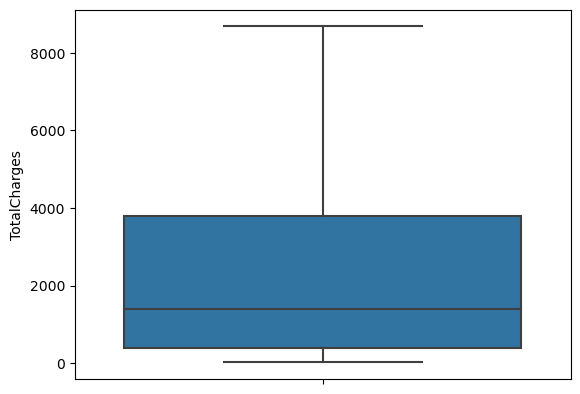

In [13]:
#visualizing total charges using box plot
import seaborn as sns
import numpy as np
sns.boxplot(data=ndf,y="TotalCharges")
np.median(ndf["TotalCharges"])

The totalcharges data is positively skewed, and most of the customers have a total charge of below 1397.475


29.0

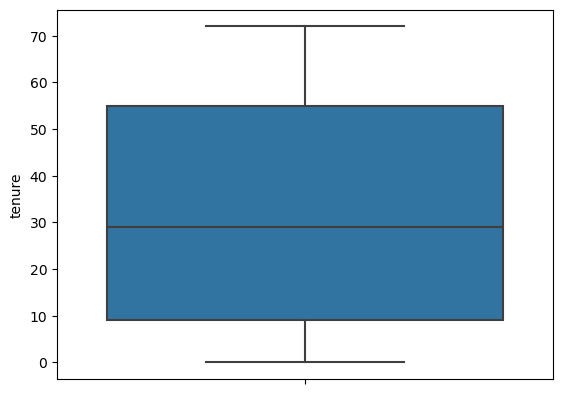

In [14]:
sns.boxplot(data=ndf,y="tenure")
np.median(ndf["tenure"])


The tenure data seems to be symmetric, and most of the customers have a tenure period of 29 days

In [15]:
# Getting the max tenure
ndf=df.toPandas()
print(ndf['tenure'].max())

72


In [16]:
# Grouping the tenure in bins of 12 months for easier analysis
import pandas as pd
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]
ndf['tenure_group'] = pd.cut(ndf.tenure, range(1, 80, 12), right=False, labels=labels)
ndf['tenure_group'].value_counts()

1 - 12     2175
61 - 72    1407
13 - 24    1024
25 - 36     832
49 - 60     832
37 - 48     762
Name: tenure_group, dtype: int64

Majority of customers tenure period range between 1 to 12 months, meaning most customers are short term subscribers

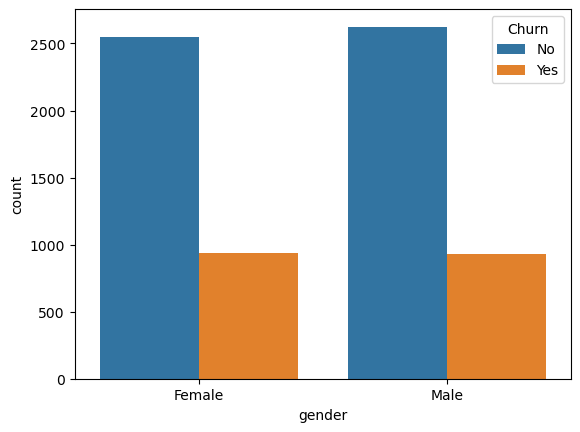

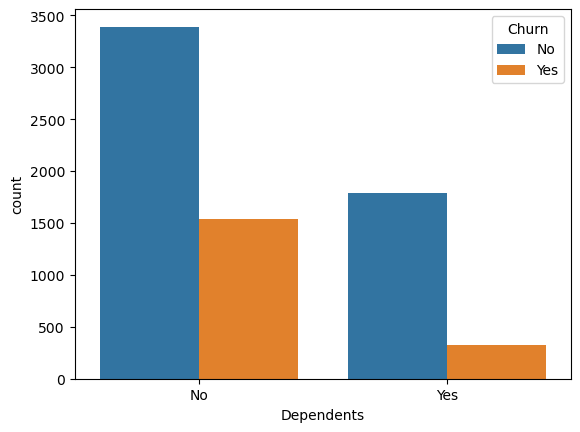

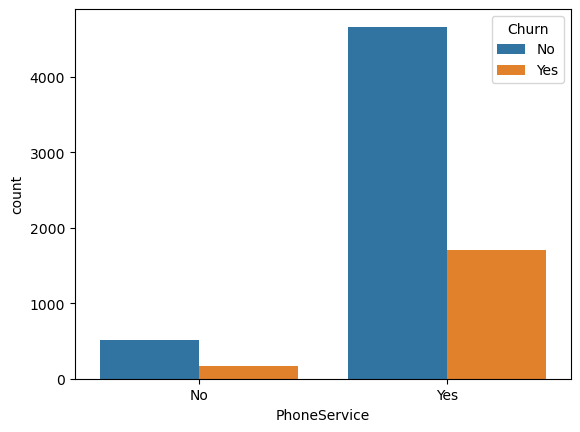

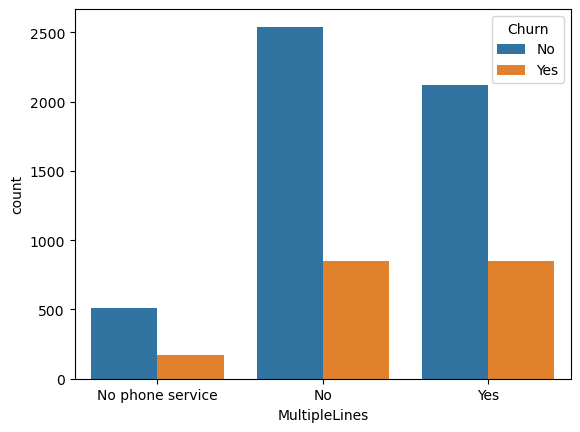

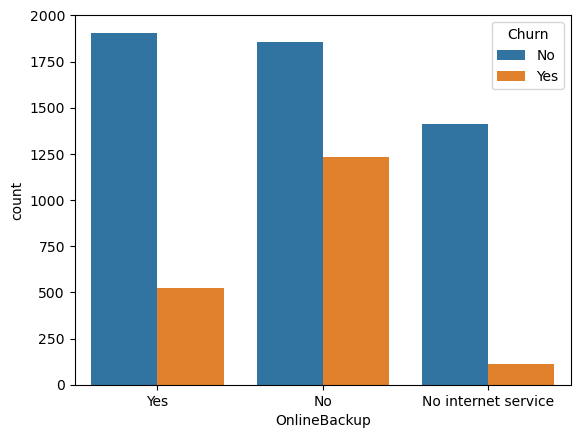

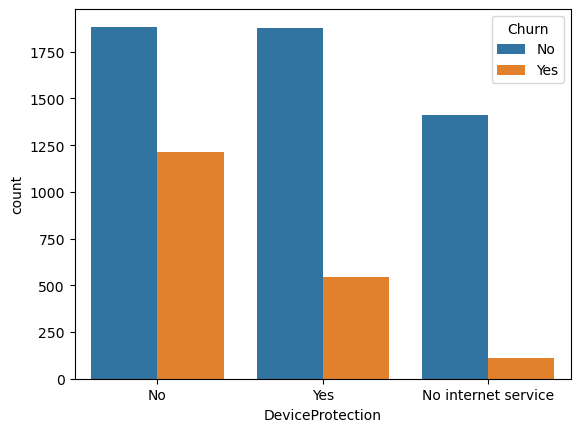

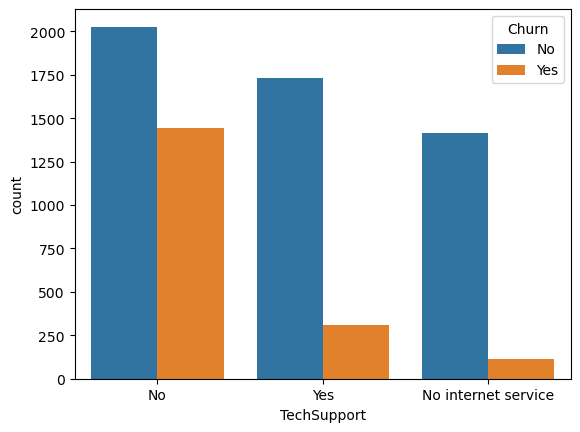

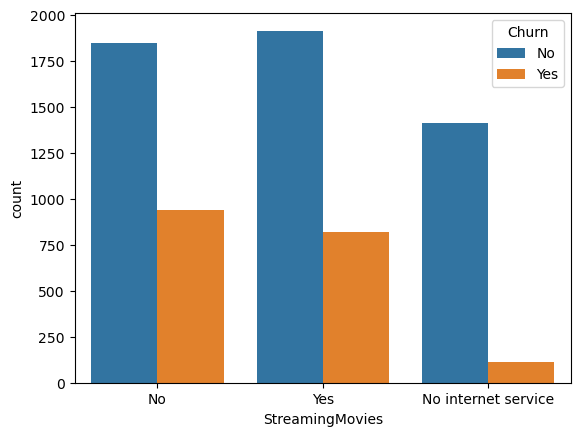

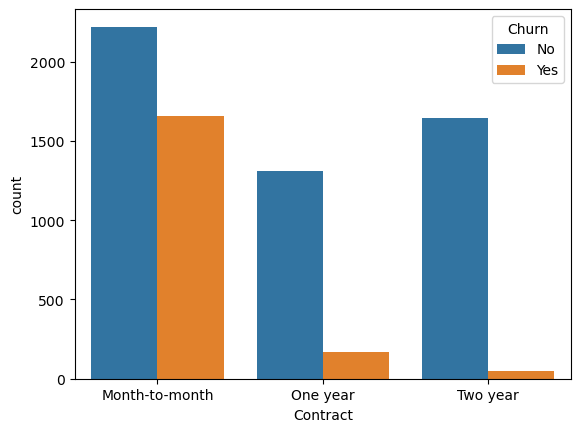

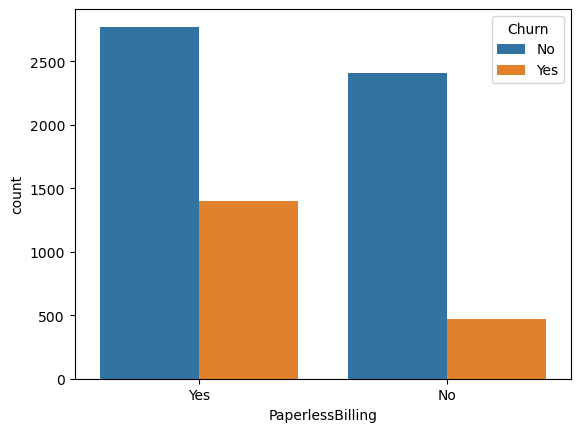

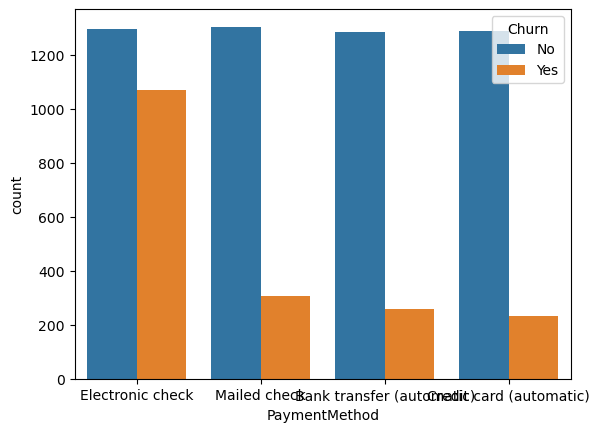

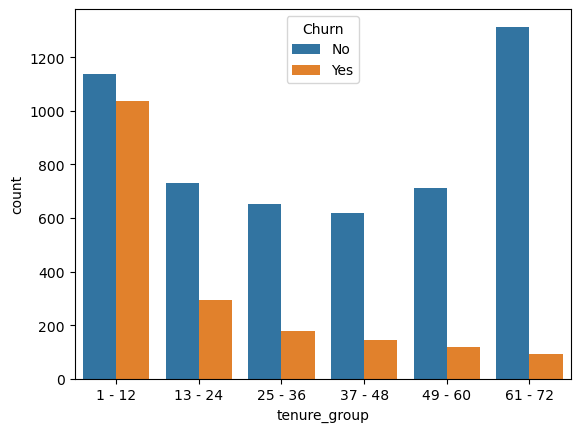

In [17]:
import matplotlib.pyplot as plt
for i, predictor in enumerate(ndf.drop(columns=['customerID','Churn', "SeniorCitizen",'TotalCharges',"tenure"])):
    plt.figure(i)
    sns.countplot(data=ndf, x=predictor, hue='Churn')


The higher the tenure period, the less likely the customers are to churn.
Electronic check medium are the highest churners.
 Contract Type - Monthly customers are more likely to churn because of no contract terms, as they are free to go customers.
No Online security, No Tech Support category are high churners.
Non senior Citizens are high churners.

In [18]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Text(0.5, 1.0, 'TotalCharges')

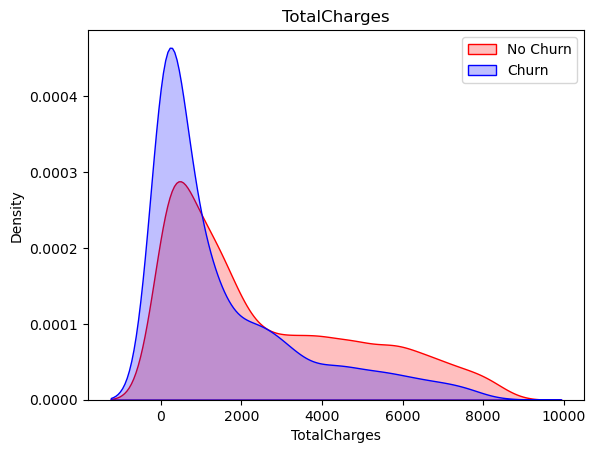

In [19]:
#converting categorical variables to dummy variables and visualizing continuous probability density curve of total charges column
import warnings
warnings.filterwarnings("ignore")
ndf=ndf.drop("customerID",axis=1)
ndf['Churn'] = np.where(df.toPandas()["Churn"] == 'Yes',1,0)
churn_data_dummies = pd.get_dummies(ndf)
TC = sns.kdeplot(churn_data_dummies.TotalCharges[(churn_data_dummies["Churn"] == 0) ],
                color="Red", shade = True)
TC = sns.kdeplot(churn_data_dummies.TotalCharges[(churn_data_dummies["Churn"] == 1) ],
                ax =TC, color="Blue", shade= True)
TC.legend(["No Churn","Churn"],loc='upper right')
TC.set_ylabel('Density')
TC.set_xlabel('TotalCharges')
TC.set_title('TotalCharges')


lower total charges result in a high churn,which is a suprising insight.However, the picture is a bit clear by combining the
fact that lower tenure which results in a high churn has a higher total charges

<Axes: >

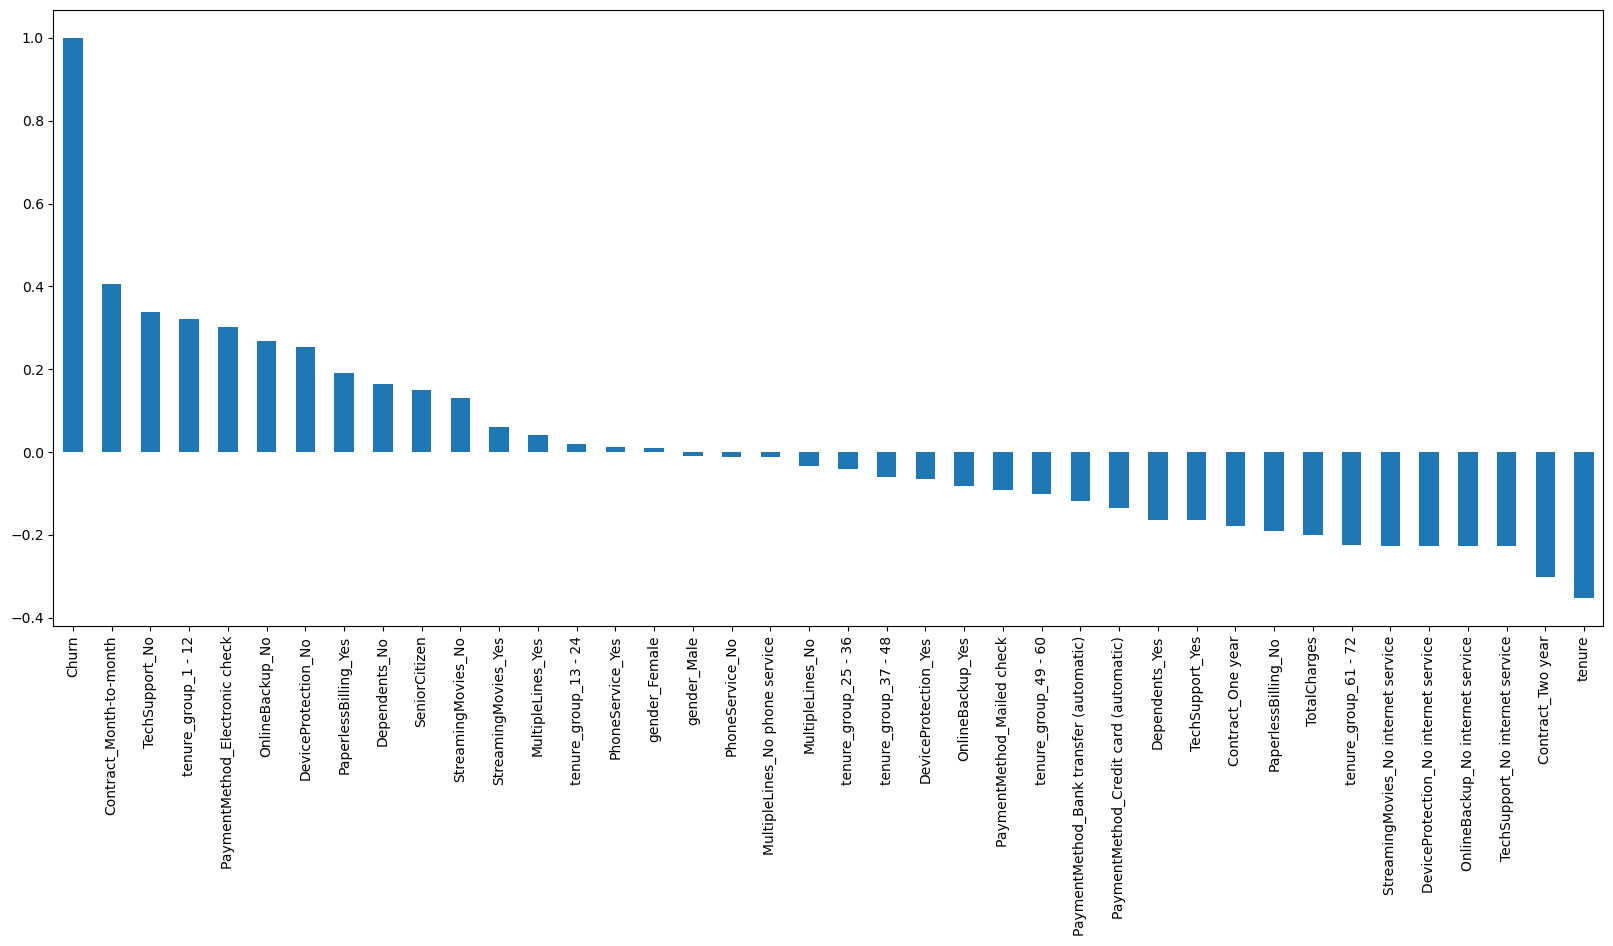

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
churn_data_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')


HIGH Churn seen in case of Month to month contracts, No online security, No Tech support, First year of subscription and Fibre Optics Internet
LOW Churn is seens in case of Long term contracts, Subscriptions without internet service and The customers engaged for 5+ years
Factors like Gender, Availability of PhoneService and # of multiple lines have almost NO impact on Churn

<Axes: >

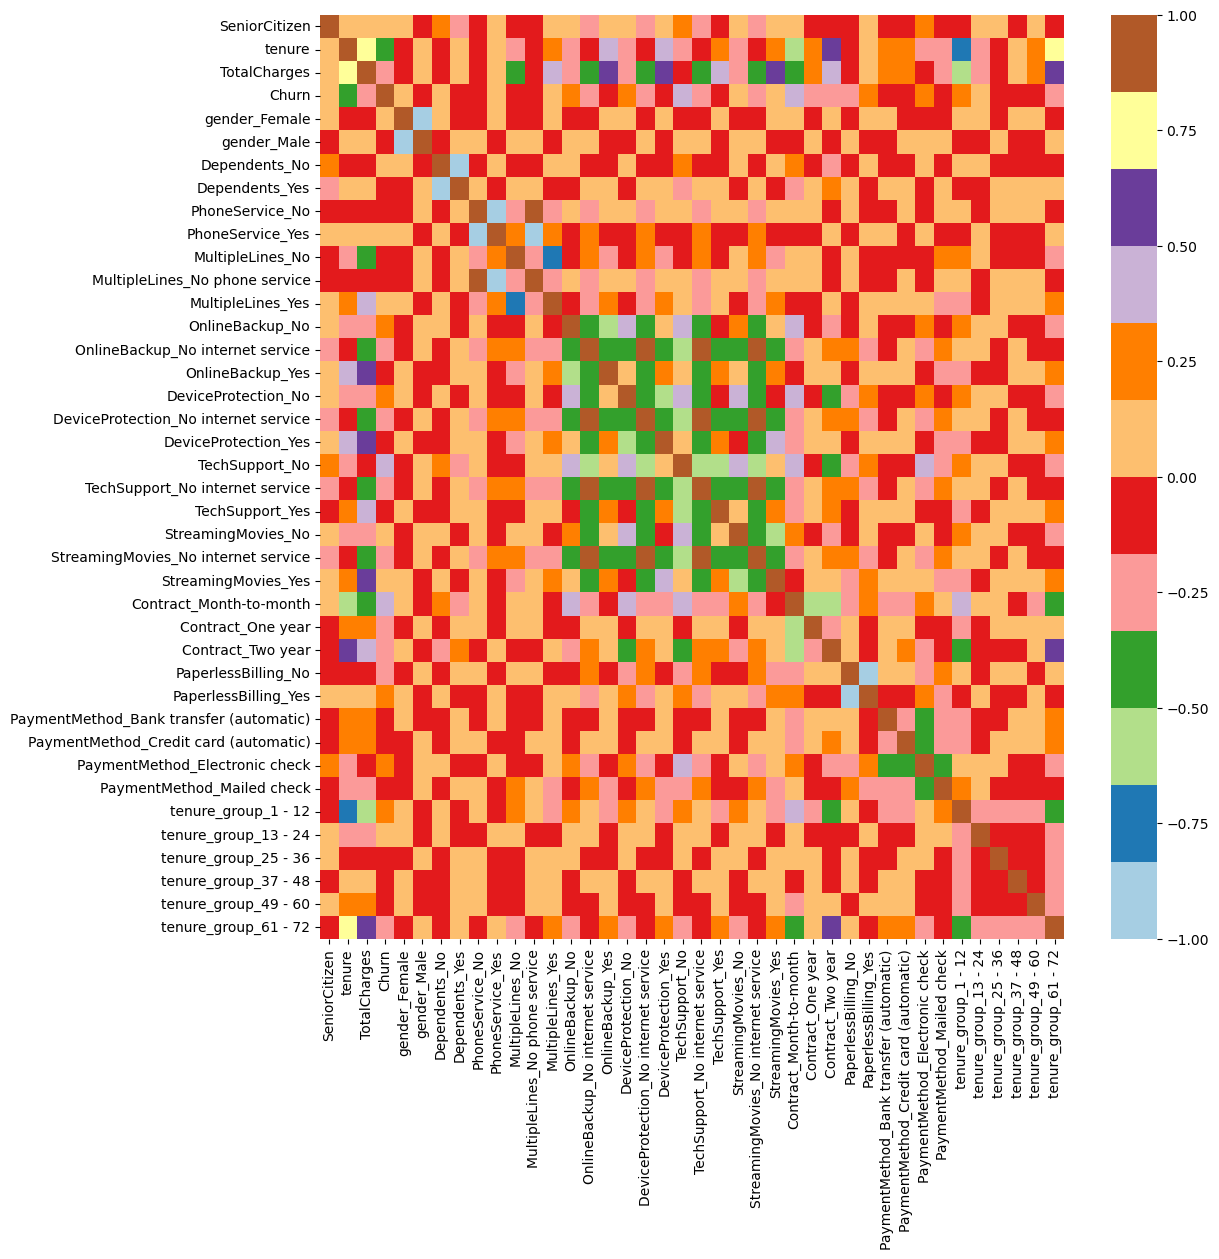

In [21]:
plt.figure(figsize=(12,12))
sns.heatmap(churn_data_dummies.corr(), cmap="Paired")

Text(0.5, 1.0, 'Histogram of total charges')

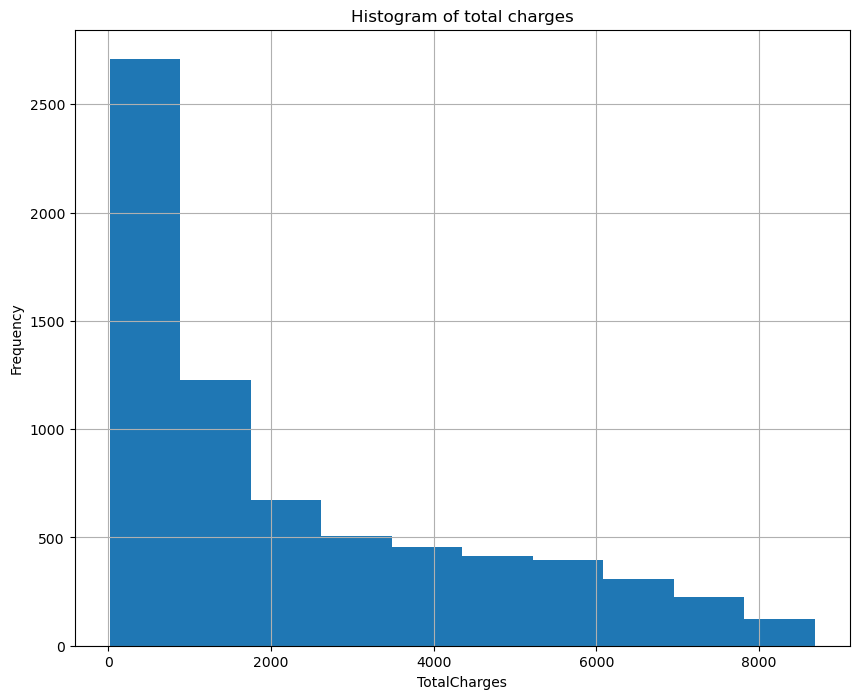

In [22]:
#Visualizing total charges using histogram
plt.figure(figsize=(10,8))
df.toPandas()["TotalCharges"].hist()
plt.xlabel('TotalCharges')
plt.ylabel('Frequency')
plt.title("Histogram of total charges")

# c) Data Cleaning and Feature Selection

In [23]:
#importing necessary packages
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report

In [24]:
#Determining the number of null values for each feature
from pyspark.sql.functions import col,count,isnan,when
df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+----------+------+------------+-------------+------------+----------------+-----------+---------------+--------+----------------+-------------+------------+-----+
|customerID|gender|SeniorCitizen|Dependents|tenure|PhoneService|MultipleLines|OnlineBackup|DeviceProtection|TechSupport|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|TotalCharges|Churn|
+----------+------+-------------+----------+------+------------+-------------+------------+----------------+-----------+---------------+--------+----------------+-------------+------------+-----+
|         0|     0|            0|         0|     0|           0|            0|           0|               0|          0|              0|       0|               0|            0|          11|    0|
+----------+------+-------------+----------+------+------------+-------------+------------+----------------+-----------+---------------+--------+----------------+-------------+------------+-----+



TotalCharges column has 11 nulls which need to be handled before buidling model

In [25]:
#dropping all rows with null values
df=df.dropna()

In [26]:
#finding the types of columns
df.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'int'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

In [27]:
# Identifying categorical columns of input
categorical_cols = [c for c, t in df.dtypes if t == "string" ]

In [28]:
#Using StringIndexer to convert categorical string columns into numerical indices.
#We then use pipeline tool to set a stage which transform each column into a numerical indices
indexers = [StringIndexer(inputCol=col, outputCol=col + "Numeric").fit(df) for col in categorical_cols]

pipeline = Pipeline(stages=indexers)
df_encoded = pipeline.fit(df).transform(df)

In [29]:
# Showing the dataset
df_encoded.toPandas()

,customerID,gender,SeniorCitizen,Dependents,tenure,PhoneService,MultipleLines,OnlineBackup,DeviceProtection,TechSupport,...,PhoneServiceNumeric,MultipleLinesNumeric,OnlineBackupNumeric,DeviceProtectionNumeric,TechSupportNumeric,StreamingMoviesNumeric,ContractNumeric,PaperlessBillingNumeric,PaymentMethodNumeric,ChurnNumeric
0,7590-VHVEG,Female,0,No,1,No,No phone service,Yes,No,No,...,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5575-GNVDE,Male,0,No,34,Yes,No,No,Yes,No,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0
2,3668-QPYBK,Male,0,No,2,Yes,No,Yes,No,No,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,7795-CFOCW,Male,0,No,45,No,No phone service,No,Yes,Yes,...,1.0,2.0,0.0,1.0,1.0,0.0,2.0,1.0,2.0,0.0
4,9237-HQITU,Female,0,No,2,Yes,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,Male,0,Yes,24,Yes,Yes,No,Yes,Yes,...,0.0,1.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0
7028,2234-XADUH,Female,0,Yes,72,Yes,Yes,Yes,Yes,No,...,0.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,3.0,0.0
7029,4801-JZAZL,Female,0,Yes,11,No,No phone service,No,No,No,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7030,8361-LTMKD,Male,1,No,4,Yes,Yes,No,No,No,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [30]:
#displaying column names
df_encoded.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges',
 'Churn',
 'customerIDNumeric',
 'genderNumeric',
 'DependentsNumeric',
 'PhoneServiceNumeric',
 'MultipleLinesNumeric',
 'OnlineBackupNumeric',
 'DeviceProtectionNumeric',
 'TechSupportNumeric',
 'StreamingMoviesNumeric',
 'ContractNumeric',
 'PaperlessBillingNumeric',
 'PaymentMethodNumeric',
 'ChurnNumeric']

In [31]:
# Defining feature columns and assembling them as a vector
assembler = VectorAssembler(
    inputCols=['SeniorCitizen','tenure','genderNumeric','TotalCharges','DependentsNumeric','PhoneServiceNumeric','MultipleLinesNumeric','OnlineBackupNumeric', 'DeviceProtectionNumeric','TechSupportNumeric',
 'StreamingMoviesNumeric','ContractNumeric','PaperlessBillingNumeric'], outputCol='features')

df_assembled = assembler.transform(df_encoded)

In [33]:
# Filtering the Input and Output columns into a new dataframe
df_assembled_filtered = df_assembled.select("features", "ChurnNumeric")

In [34]:
df_assembled_filtered.toPandas()

,features,ChurnNumeric
0,"(0.0, 1.0, 1.0, 29.85, 0.0, 1.0, 2.0, 1.0, 0.0...",0.0
1,"(0.0, 34.0, 0.0, 1889.5, 0.0, 0.0, 0.0, 0.0, 1...",0.0
2,"(0.0, 2.0, 0.0, 108.15, 0.0, 0.0, 0.0, 1.0, 0....",1.0
3,"[0.0, 45.0, 0.0, 1840.75, 0.0, 1.0, 2.0, 0.0, ...",0.0
4,"(0.0, 2.0, 1.0, 151.65, 0.0, 0.0, 0.0, 0.0, 0....",1.0
...,...,...
7027,"[0.0, 24.0, 0.0, 1990.5, 1.0, 0.0, 1.0, 0.0, 1...",0.0
7028,"[0.0, 72.0, 1.0, 7362.9, 1.0, 0.0, 1.0, 1.0, 1...",0.0
7029,"(0.0, 11.0, 1.0, 346.45, 1.0, 1.0, 2.0, 0.0, 0...",0.0
7030,"(1.0, 4.0, 0.0, 306.6, 0.0, 0.0, 1.0, 0.0, 0.0...",1.0


# d) Building Model

In [35]:
# Train-Test split
train_data, test_data = df_assembled_filtered.randomSplit([0.8, 0.2])

In [36]:
# Train a Decision Tree model
dtc = DecisionTreeClassifier(featuresCol='features', labelCol="ChurnNumeric")
model = dtc.fit(train_data)

In [37]:
# Predictions using test_data
predictions = model.transform(test_data)

In [38]:
#"Raw prediction" for each possible label which gives a measure of confidence(where larger = more confident).
predictions.toPandas()

,features,ChurnNumeric,rawPrediction,probability,prediction
0,"(1.0, 1.0, 1.0, 69.25, 0.0, 0.0, 0.0, 0.0, 0.0...",1.0,"[391.0, 632.0]","[0.38220918866080156, 0.6177908113391984]",1.0
1,"(1.0, 1.0, 1.0, 69.6, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.0,"[391.0, 632.0]","[0.38220918866080156, 0.6177908113391984]",1.0
2,"(1.0, 1.0, 1.0, 69.95, 0.0, 0.0, 0.0, 0.0, 0.0...",1.0,"[391.0, 632.0]","[0.38220918866080156, 0.6177908113391984]",1.0
3,"(1.0, 1.0, 1.0, 70.45, 0.0, 0.0, 0.0, 0.0, 0.0...",1.0,"[391.0, 632.0]","[0.38220918866080156, 0.6177908113391984]",1.0
4,"(1.0, 1.0, 1.0, 79.2, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.0,"[391.0, 632.0]","[0.38220918866080156, 0.6177908113391984]",1.0
...,...,...,...,...,...
1379,"[1.0, 72.0, 1.0, 6697.35, 0.0, 0.0, 1.0, 1.0, ...",0.0,"[2333.0, 178.0]","[0.9291119076065313, 0.07088809239346874]",0.0
1380,"[1.0, 72.0, 1.0, 7677.4, 0.0, 0.0, 1.0, 1.0, 0...",0.0,"[2333.0, 178.0]","[0.9291119076065313, 0.07088809239346874]",0.0
1381,"[1.0, 72.0, 1.0, 7774.05, 0.0, 0.0, 1.0, 1.0, ...",0.0,"[2333.0, 178.0]","[0.9291119076065313, 0.07088809239346874]",0.0
1382,"[1.0, 72.0, 1.0, 8075.35, 0.0, 0.0, 1.0, 0.0, ...",0.0,"[2333.0, 178.0]","[0.9291119076065313, 0.07088809239346874]",0.0


In [39]:
#Evaluating the model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="ChurnNumeric")
area_under_roc = evaluator.evaluate(predictions)
print("Area Under ROC:", area_under_roc)

Area Under ROC: 0.7466842272462542


In [40]:
#  Convert 'predictions' DataFrame to an RDD of (prediction, label) tuples
prediction_and_label = predictions.select("prediction", "ChurnNumeric").rdd.map(lambda row: (float(row["prediction"]), float(row["ChurnNumeric"])))
prediction_and_label

PythonRDD[268] at RDD at PythonRDD.scala:53

In [41]:
# Using 'collect' to show the content of a RDD
for pred, label in prediction_and_label.collect():
    print(f"Prediction: {pred}, Actual Label: {label}")

Prediction: 1.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 0.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 0.0
Prediction: 1.0, Actual Label: 0.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 0.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 0.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 0.0
Prediction: 1.0, Actual Label: 0.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 1.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 1.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 1.0
Prediction: 0.0, Act

In [42]:
# Create a MulticlassMetrics object to develop the Confusion Matrix
metrics = MulticlassMetrics(prediction_and_label)
confusion_matrix = metrics.confusionMatrix()
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
DenseMatrix([[897., 113.],
             [181., 193.]])


# feature importances

In [43]:
#defining a function for extracting important features
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))


In [44]:
#calling the function defined for extracting feature scores
ExtractFeatureImp(model.featureImportances, df_assembled_filtered, "features").head(30)


,idx,name,vals,score
11,11,ContractNumeric,"[Month-to-month, Two year, One year]",0.681326
9,9,TechSupportNumeric,"[No, Yes, No internet service]",0.166253
1,1,tenure,NaN,0.129265
0,0,SeniorCitizen,NaN,0.023156
2,3,TotalCharges,NaN,0.000000
3,2,genderNumeric,"[Male, Female]",0.000000
4,4,DependentsNumeric,"[No, Yes]",0.000000
5,5,PhoneServiceNumeric,"[Yes, No]",0.000000
6,6,MultipleLinesNumeric,"[No, Yes, No phone service]",0.000000
7,7,OnlineBackupNumeric,"[No, Yes, No internet service]",0.000000


In [45]:
print(model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_2245853e6011, depth=5, numNodes=11, numClasses=2, numFeatures=13
  If (feature 11 in {1.0,2.0})
   Predict: 0.0
  Else (feature 11 not in {1.0,2.0})
   If (feature 9 in {1.0,2.0})
    Predict: 0.0
   Else (feature 9 not in {1.0,2.0})
    If (feature 1 <= 10.5)
     Predict: 1.0
    Else (feature 1 > 10.5)
     If (feature 0 <= 0.5)
      Predict: 0.0
     Else (feature 0 > 0.5)
      If (feature 1 <= 58.5)
       Predict: 1.0
      Else (feature 1 > 58.5)
       Predict: 0.0



The most important feature is contract type

# Handling Missing Values

In [60]:
#The most important attribute is the contract type
from pyspark.sql.functions import when, col
# Calculating the most frequent value in the 'contract' column
most_frequent_contract_type = df.groupBy('contract').count().orderBy('count', ascending=False).first()[0]

# Imputing missing values in the 'contract' column with the most frequent category
df = df.withColumn('contract', when(col('contract').isNull(), most_frequent_contract_type).otherwise(col('contract')))
